MLP (Multi Layer Perceptron) Classifier is the feedforward artificial neural network implementation of Scikit-Learn library.

MLPClassifier is used to predict whether a patient has diabetes based on a set of diagnostics.

Outline of the work is as follows:

* Load Data
* Split Data
* Visualization and Outlier Check
* Standardization
* Correlation Analysis
* Feature Importance
* Train MLP
* Test MLP

In [1]:
import numpy as np
import itertools
import os
import pandas as pd
import seaborn as sea

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE

import xgboost as xgb
from xgboost import plot_importance

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
sea.set_style("darkgrid")

## Load Data

Pima Indians Diabetes dataset is used.

In [3]:
data = pd.read_csv("E:\syntax code\python\jupytr\dataset\diabetes.csv")

data.head(10).style.set_precision(2). \
                    set_properties(**{"min-width": "60px"}). \
                    set_properties(**{"color": "#111111"}). \
                    set_properties(**{"text-align": "center"}). \
                    set_table_styles([
                          {"selector": "th",
                           "props": [("font-weight", "bold"),
                                     ("font-size", "12px"),
                                     ("text-align", "center")]},
                          {"selector": "tr:nth-child(even)",
                           "props": [("background-color", "#f2f2f2")]},
                          {"selector": "tr:nth-child(odd)",
                           "props": [("background-color", "#fdfdfd")]},
                          {"selector": "tr:hover",
                           "props": [("background-color", "#bcbcbc")]}])

C:\Users\Lucky_seven\AppData\Local\Temp\ipykernel_4524\2499443456.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  data.head(10).style.set_precision(2). \


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.60,0.63,50,1
1,1,85,66,29,0,26.60,0.35,31,0
2,8,183,64,0,0,23.30,0.67,32,1
3,1,89,66,23,94,28.10,0.17,21,0
4,0,137,40,35,168,43.10,2.29,33,1
5,5,116,74,0,0,25.60,0.20,30,0
6,3,78,50,32,88,31.00,0.25,26,1
7,10,115,0,0,0,35.30,0.13,29,0
8,2,197,70,45,543,30.50,0.16,53,1
9,8,125,96,0,0,0.00,0.23,54,1


There are 8 features and Outcome is the target variable.

* Pregnancies
* Glucose
* BloodPressure
* SkinThickness
* Insulin
* BMI (Body mass index)
* DiabetesPedigreeFunction
* Age

Features are assigned to data_X and corresponding labels to data_Y. Pandas info shows column (feature) data types and number of non-null values.

In [4]:
# disable SettingWithCopyWarning messages
pd.options.mode.chained_assignment = None

data_X = data.loc[:, data.columns != "Outcome"]
data_Y = data[["Outcome"]]

print("data_X info:\n")
data_X.info()
print("\ndata_Y info:\n")
data_Y.info()

data_X info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 48.1 KB

data_Y info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Outcome  768 non-null    int64
dtypes: int64(1)
memory usage: 6.1 KB


Dataset has 768 rows (training samples). All features are numeric. And it seems there aren't any missing values. Here, one point requires extra attention. In your dataset, missing values may be encoded other than **NaN** or **NA**. For example, if you go and change some cells in dataset to **Na** or **NAN** and load it again and check info, **Pandas** won't recognize them as null values. So, **Pandas** may not detect these cells as missing. In our case, dataset is small and a short visual inspection reveals no missing values. But there is another point. Some cells may be encoded with an unlikely input. For example, 0 may indicate a missing value for a numeric feature. We will return this issue later.

Number of classes and their distribution is inspected in below cell.

In [5]:
data_Y["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

There are two classes as expected, a patient has diabetes or doesn't have.

## Split Data

Dataset is divided into train and test sets. We use stratify parameter of train_test_split function to get the same class distribution across train and test sets.

In [6]:
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y,
                                                    test_size=0.2,
                                                    stratify=data_Y,
                                                    random_state=0)

train_X.reset_index(drop=True, inplace=True);
test_X.reset_index(drop=True, inplace=True);
train_Y.reset_index(drop=True, inplace=True);
test_Y.reset_index(drop=True, inplace=True);

## Visualization and Outlier Check

Outliers degrade the learning performance. Outlier analysis is performed for each feature one-by-one. We use quartile analysis for outlier detection. For each feature, there are two plots below. Distribution of feature is on the left. Box plot of the same feature is on the right. Both of them are analyzed together to get an idea about the outliers. From this point on, lower whisker of the boxplot is denoted as LW and upper whisker is denoted as UW.

In order to draw a boxplot, feature data is divided into four. Three cut points are needed. These points are lower quartile (or first quartile), median (or second quartile) and upper quartile (or third quartile). First quartile is the median of the data lower than second quartile. Third quartile is the median of the data greater than the second quartile. Interquartile range (IQR) is found subtracting lower quartile from upper quartile. Outliers are determined using lower, upper quartiles and IQR.

In [7]:
def plots(feature):
    fig = plt.figure(constrained_layout = True, figsize=(10,3))
    gs = gridspec.GridSpec(nrows=1, ncols=4, figure=fig)

    ax1 = fig.add_subplot(gs[0,:3])    
    sea.distplot(train_X.loc[train_Y["Outcome"]==0,feature],
                 kde = False, color = "#004a4d", norm_hist=False,
                 hist_kws = dict(alpha=0.8), bins=40,
                 label="Not Diabetes", ax=ax1);
    sea.distplot(train_X.loc[train_Y["Outcome"]==1,feature],
                 kde = False, color = "#7d0101", norm_hist=False,
                 hist_kws = dict(alpha=0.6), bins=40,
                 label="Diabetes", ax=ax1);
    ax2 = fig.add_subplot(gs[0,3])    
    sea.boxplot(train_X[feature], orient="v", color = "#989100",
                width = 0.2, ax=ax2);
    
    ax1.legend(loc="upper right");

### Feature 0 - Pregnancies

C:\Users\Lucky_seven\AppData\Local\Temp\ipykernel_4524\3164043502.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sea.distplot(train_X.loc[train_Y["Outcome"]==0,feature],
C:\Users\Lucky_seven\AppData\Local\Temp\ipykernel_4524\3164043502.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sea.distplot(train_X.loc[tra

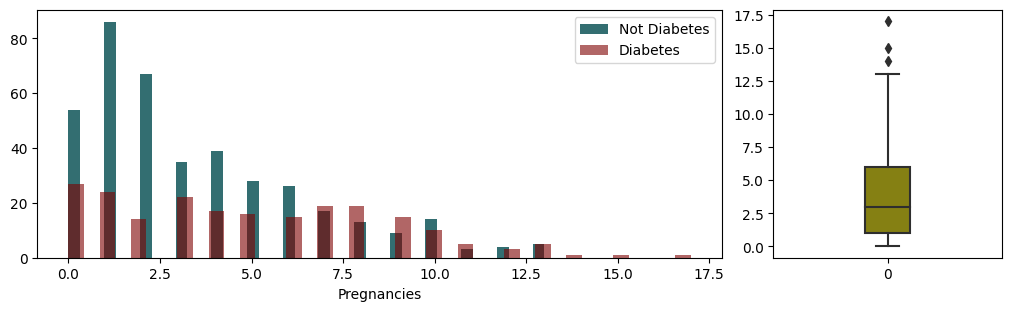

In [8]:
plots("Pregnancies")

For Pregnancies feature, there are some measurements above upper whisker. These are rare events. We replace them with 95th quantile.

In [9]:
Q1 = train_X["Pregnancies"].quantile(0.25)
Q3 = train_X["Pregnancies"].quantile(0.75)
q95th = train_X["Pregnancies"].quantile(0.95)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["Pregnancies"] = np.where(train_X["Pregnancies"] > UW,
                                  q95th, train_X["Pregnancies"])

### Feature 1 - Glucose

C:\Users\Lucky_seven\AppData\Local\Temp\ipykernel_4524\3164043502.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sea.distplot(train_X.loc[train_Y["Outcome"]==0,feature],
C:\Users\Lucky_seven\AppData\Local\Temp\ipykernel_4524\3164043502.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sea.distplot(train_X.loc[tra

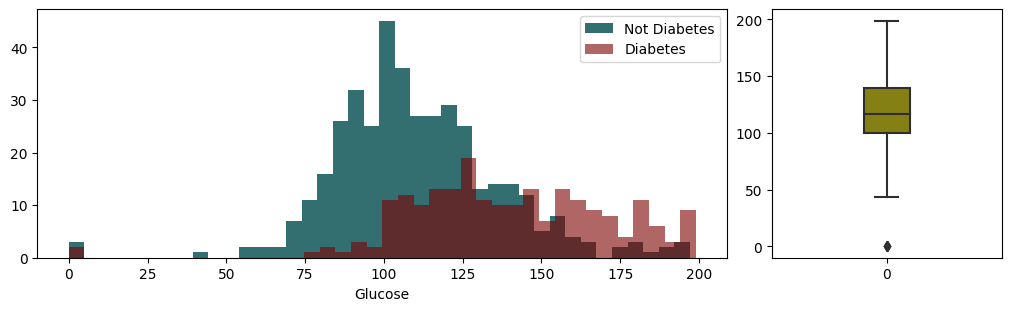

In [10]:
plots("Glucose")

There are some 0 values for **Glucose**. We can deem 0 values as placeholder for missing data. So we replace them with median.

In [11]:
med = train_X["Glucose"].median()
train_X["Glucose"] = np.where(train_X["Glucose"] == 0, med, train_X["Glucose"])

### Feature 2 - BloodPressure

C:\Users\Lucky_seven\AppData\Local\Temp\ipykernel_4524\3164043502.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sea.distplot(train_X.loc[train_Y["Outcome"]==0,feature],
C:\Users\Lucky_seven\AppData\Local\Temp\ipykernel_4524\3164043502.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sea.distplot(train_X.loc[tra

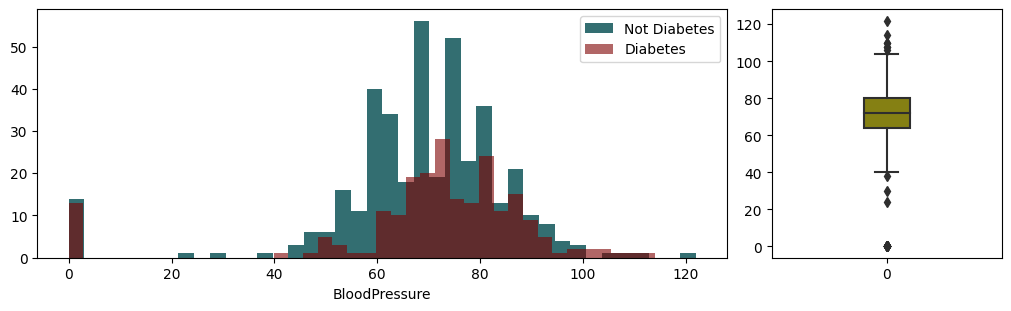

In [12]:
plots("BloodPressure")

There are some 0 values for **BloodPressure** which is unlikely. So we replace them with median. Also, we replace values lower than LW (except zeros) with 5th quantile and replace values greater than UW with 95th quantile.

In [13]:
med = train_X["BloodPressure"].median()
q5th = train_X["BloodPressure"].quantile(0.05)
q95th = train_X["BloodPressure"].quantile(0.95)
Q1 = train_X["BloodPressure"].quantile(0.25)
Q3 = train_X["BloodPressure"].quantile(0.75)
IQR = Q3 - Q1
LW = Q1 - 1.5*IQR
UW = Q3 + 1.5*IQR

train_X["BloodPressure"] = np.where(train_X["BloodPressure"] == 0,
                                    med, train_X["BloodPressure"])
train_X["BloodPressure"] = np.where(train_X["BloodPressure"] < LW,
                                    q5th, train_X["BloodPressure"])
train_X["BloodPressure"] = np.where(train_X["BloodPressure"] > UW,
                                    q95th, train_X["BloodPressure"])

### Feature 3 - SkinThickness

C:\Users\Lucky_seven\AppData\Local\Temp\ipykernel_4524\3164043502.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sea.distplot(train_X.loc[train_Y["Outcome"]==0,feature],
C:\Users\Lucky_seven\AppData\Local\Temp\ipykernel_4524\3164043502.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sea.distplot(train_X.loc[tra

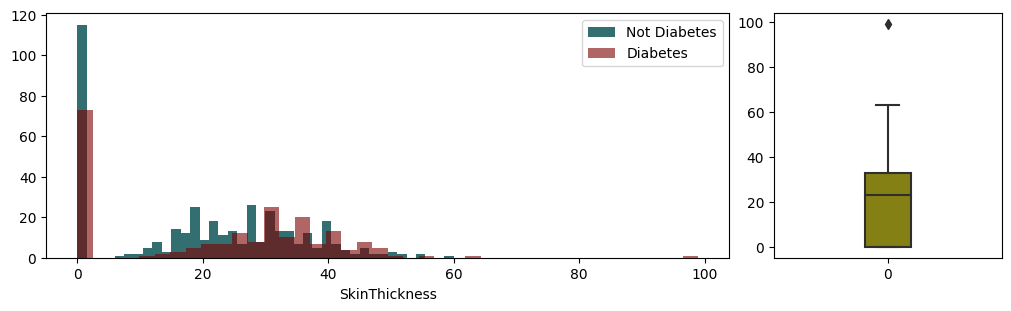

In [14]:
plots("SkinThickness")

There are some 0 values for **SkinThickness** which is unlikely. So we replace them with median. Also, we replace values greater than UW with 95th quantile.

In [15]:
med = train_X["SkinThickness"].median()
q95th = train_X["SkinThickness"].quantile(0.95)
Q1 = train_X["SkinThickness"].quantile(0.25)
Q3 = train_X["SkinThickness"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["SkinThickness"] = np.where(train_X["SkinThickness"] == 0,
                                    med, train_X["SkinThickness"])
train_X["SkinThickness"] = np.where(train_X["SkinThickness"] > UW,
                                    q95th, train_X["SkinThickness"])

### Feature 4 - Insulin

C:\Users\Lucky_seven\AppData\Local\Temp\ipykernel_4524\3164043502.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sea.distplot(train_X.loc[train_Y["Outcome"]==0,feature],
C:\Users\Lucky_seven\AppData\Local\Temp\ipykernel_4524\3164043502.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sea.distplot(train_X.loc[tra

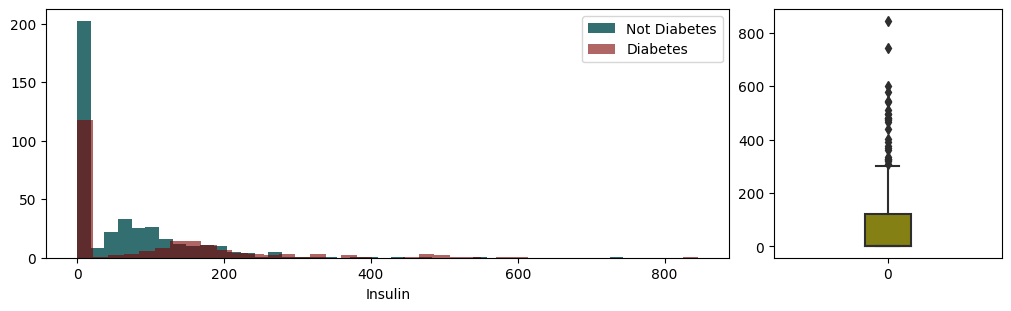

In [16]:
plots("Insulin")

There are some 0 values for **Insulin** which is unlikely. So we replace them with 60th quantile becuse median is 0. Also, we replace values greater than UW with 95th quantile.

In [17]:
q60th = train_X["Insulin"].quantile(0.60)
q95th = train_X["Insulin"].quantile(0.95)
Q1 = train_X["Insulin"].quantile(0.25)
Q3 = train_X["Insulin"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["Insulin"] = np.where(train_X["Insulin"] == 0,
                              q60th, train_X["Insulin"])
train_X["Insulin"] = np.where(train_X["Insulin"] > UW,
                              q95th, train_X["Insulin"])

### Feature 5 - BMI

C:\Users\Lucky_seven\AppData\Local\Temp\ipykernel_4524\3164043502.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sea.distplot(train_X.loc[train_Y["Outcome"]==0,feature],
C:\Users\Lucky_seven\AppData\Local\Temp\ipykernel_4524\3164043502.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sea.distplot(train_X.loc[tra

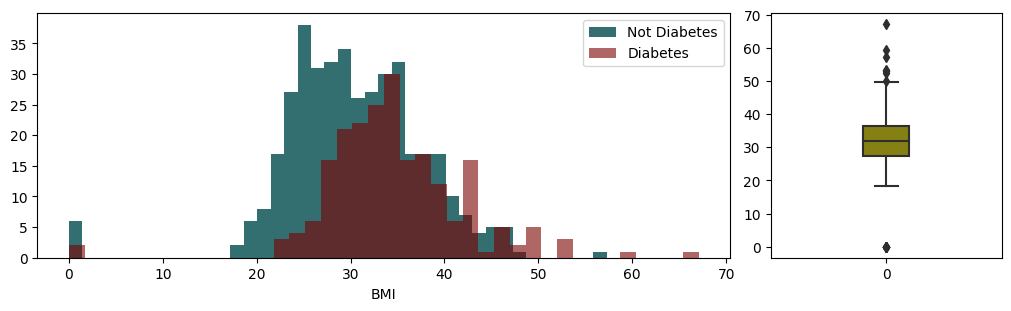

In [18]:
plots("BMI")

There are some 0 values for **BMI**. We replace them with median. Also, we replace values greater than UW with q95th.

In [19]:
med = train_X["BMI"].median()
q95th = train_X["BMI"].quantile(0.95)
Q1 = train_X["BMI"].quantile(0.25)
Q3 = train_X["BMI"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["BMI"] = np.where(train_X["BMI"] == 0,
                          med, train_X["BMI"])
train_X["BMI"] = np.where(train_X["BMI"] > UW,
                          q95th, train_X["BMI"])

### Feature 6 - DiabetesPedigreeFunction

C:\Users\Lucky_seven\AppData\Local\Temp\ipykernel_4524\3164043502.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sea.distplot(train_X.loc[train_Y["Outcome"]==0,feature],
C:\Users\Lucky_seven\AppData\Local\Temp\ipykernel_4524\3164043502.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sea.distplot(train_X.loc[tra

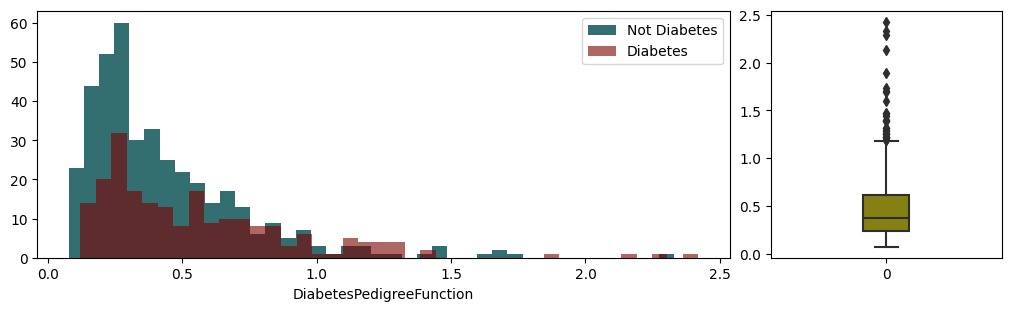

In [20]:
plots("DiabetesPedigreeFunction")

We replace values greater than UW with 95th quantile.

In [21]:
q95th = train_X["DiabetesPedigreeFunction"].quantile(0.95)
Q1 = train_X["DiabetesPedigreeFunction"].quantile(0.25)
Q3 = train_X["DiabetesPedigreeFunction"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["DiabetesPedigreeFunction"] = np.where(
                        train_X["DiabetesPedigreeFunction"] > UW,
                        q95th, train_X["DiabetesPedigreeFunction"])

### Feature 7 - Age

C:\Users\Lucky_seven\AppData\Local\Temp\ipykernel_4524\3164043502.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sea.distplot(train_X.loc[train_Y["Outcome"]==0,feature],
C:\Users\Lucky_seven\AppData\Local\Temp\ipykernel_4524\3164043502.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sea.distplot(train_X.loc[tra

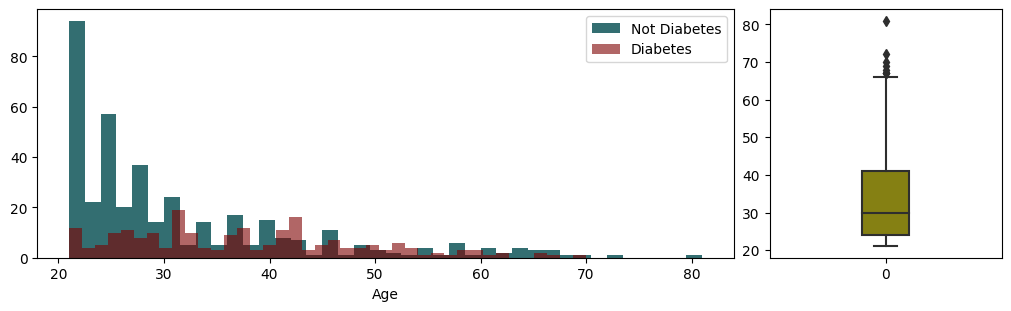

In [22]:
plots("Age")

There are some measurements above UW due to rare events. We replace them with 95th quantile.

In [23]:
q95th = train_X["Age"].quantile(0.95)
Q1 = train_X["Age"].quantile(0.25)
Q3 = train_X["Age"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["Age"] = np.where(train_X["Age"] > UW,
                          q95th, train_X["Age"])

## Standardization

To increase the learning performance, input features are standardized. Mean and standard deviation of the feature are computed. Then, mean is subtracted from each sample of the feature and result is divided by standard deviation. The aim is to transform the feature to have mean of 0 and standard deviation of 1. **StandardScaler** of **scikit-learn** is used. A **StandardScaler** is fit to the feature in **train_X**, then this scaler transforms the same feature in **train_X** and **test_X**.

In [24]:
feature_names = train_X.columns

scaler = StandardScaler()

# fit to train_X
scaler.fit(train_X)

# transform train_X
train_X = scaler.transform(train_X)
train_X = pd.DataFrame(train_X, columns = feature_names)

# transform test_X
test_X = scaler.transform(test_X)
test_X = pd.DataFrame(test_X, columns = feature_names)

## Correlation Analysis

Linear correlations between features and also between features and output are computed. **Pandas corr** function is used to compute correlation matrix and **Seaborn heatmap** is used for plotting.

C:\Users\Lucky_seven\AppData\Local\Temp\ipykernel_4524\1762343926.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))


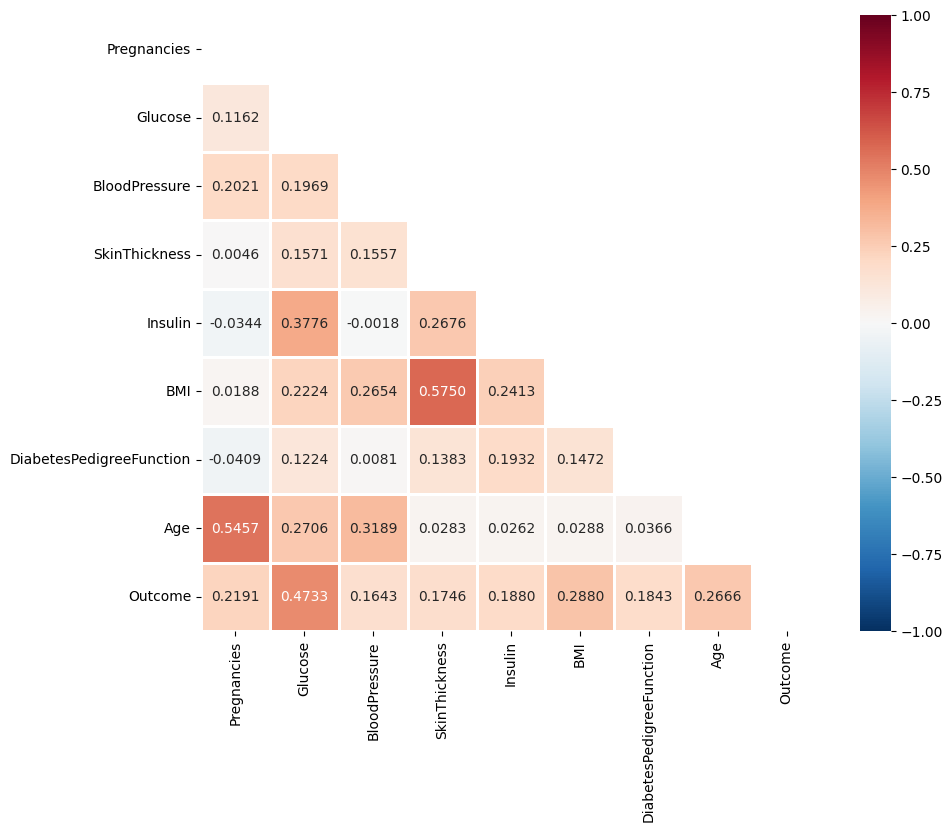

In [25]:
corr_matrix = pd.concat([train_X, train_Y], axis=1).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

plt.figure(figsize=(10,8))
sea.heatmap(corr_matrix,annot=True, fmt=".4f",
            vmin=-1, vmax=1, linewidth = 1,
            center=0, mask=mask,cmap="RdBu_r");

Correlation matrix shows that there are mild correlations between **SkinThickness-BMI** and **Age-Pregnancies**. **Outcome** has the highest linear correlation with **Glucose**.

## Feature Importance

Feature importance analysis methods can be divided into 3 broad categories:

* Filter method: Calculating a metric like correlation coefficient between each feature and output separately as we did above. In this method all features are evaluated independently.

* Embedded methods: Methods like logistic regression or linear regression learn the coefficients that multiply each feature. The magnitude of the coefficients are associated with the importance of the features. Also, tree based methods like random forests or gradient tree boosting learn feature importances during training process. In embedded methods, all features are evaluated jointly.

* Wrapper methods: Basically you have an estimator and you train this estimator with the subsets of features. The subset giving the best score is selected and other features are eliminated.

In [26]:
# logistic regression with l1 penalty - embedded method
lr1 = LogisticRegression(random_state=0, penalty="l1",
            class_weight="balanced", solver="saga", max_iter=5000)
lr1.fit(train_X, train_Y.values.ravel())

lr1.coef_

array([[ 3.60358322e-01,  1.06754141e+00, -2.50971359e-02,
        -9.81326043e-05, -6.49737080e-02,  5.74505582e-01,
         3.35113887e-01,  2.71385240e-01]])

In [27]:
# logistic regression with l2 penalty - embedded method
lr2 = LogisticRegression(random_state=0, penalty="l2",
            class_weight="balanced", solver="saga", max_iter=5000)
lr2.fit(train_X, train_Y.values.ravel())

lr2.coef_

array([[ 0.36506112,  1.07199682, -0.04073014, -0.01616834, -0.07560637,
         0.59537491,  0.34399744,  0.28125417]])

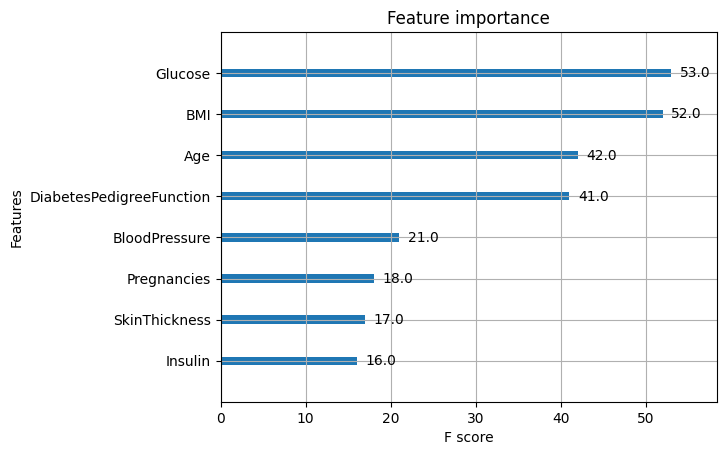

In [28]:
# xgboost - embedded method
gb = xgb.XGBClassifier(booster="gbtree",
                      learning_rate=0.15,
                      max_depth=4,
                      n_estimators=20,
                      random_state=0)
gb.fit(train_X, train_Y.values.ravel())

plot_importance(gb);

In [29]:
# recursive feature elimination with logistic regression - wrapper method
lr3 = LogisticRegression(random_state=0, penalty="l2",
            class_weight="balanced", solver="saga", max_iter=5000)
rfe_lr3 = RFE(lr3, n_features_to_select=7)
rfe_lr3.fit(train_X, train_Y.values.ravel())

print(rfe_lr3.support_)

[ True  True  True False  True  True  True  True]


First three analysis mark BloodPressure, SkinThickness and Insulin as the least important features. Note that these features have very low correlation with Outcome. RFE marks SkinThickness as the least important.

In [30]:
train_X.drop("SkinThickness", axis=1, inplace=True)
test_X.drop("SkinThickness", axis=1, inplace=True)

## Train MLP

MLPClassifier with single hidden layer is used for diabetes prediction.

In [31]:
clf = MLPClassifier(solver="adam", max_iter=5000, activation = "relu",
                    hidden_layer_sizes = (12),                      
                    alpha = 0.01,
                    batch_size = 64,
                    learning_rate_init = 0.001,
                    random_state=2)

clf.fit(train_X, train_Y.values.ravel());

## Test MLP

In [32]:
print(classification_report(test_Y, clf.predict(test_X),
                            digits = 4,
                            target_names=["Not Diabetes",
                                          "Diabetes"]))

              precision    recall  f1-score   support

Not Diabetes     0.8624    0.9400    0.8995       100
    Diabetes     0.8667    0.7222    0.7879        54

    accuracy                         0.8636       154
   macro avg     0.8645    0.8311    0.8437       154
weighted avg     0.8639    0.8636    0.8604       154

